In [ ]:
%%capture --no-stderr

%pip install --upgrade --quiet langchain-community langchainhub langgraph clickhouse-sqlalchemy sqlalchemy

: 

In [ ]:
from sqlalchemy import create_engine, Column, MetaData, literal

uri = ''

engine = create_engine(uri)

In [4]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase(engine=engine)
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM datalake.transactions LIMIT 10;")

clickhouse
['transactions']


"[(None, '2901855', '65', datetime.date(2024, 1, 10), datetime.datetime(2024, 1, 9, 16, 0), '1126790405', '563146601', '5000000202848827', 'Decrease', -20000, 70090, 90090, 'PHONE', '2401893', 'BRANCHUSERNAME', 'Mobile Legends, 7048159468995897115', None, 'Gaming', '25', 'D54D148D912657A5DFF2C0FB124774889C535459C619375A60F4D3847D0A168A0A8CD97E00F78CD36ED52F60FD66553782AF22A3A2741171B36EE2DE3849B25A', '4ED4DDC8274C0EC76E3EB08790CF402488CA7B9D8A1768B423F791B95093DAF76434D1FB1B982E6D0E23F4806F917B6B42E4CD3398905ABEE646DA90F7B521D1', 'D54D148D912657A5DFF2C0FB124774889C535459C619375A60F4D3847D0A168A0A8CD97E00F78CD36ED52F60FD66553782AF22A3A2741171B36EE2DE3849B25A', None, None, None, '9D343F99EB8230FC183F186CAC257E405778ADF113D54135D401BF4A04FD70B065A7DE54030C6477080D90EDE2FCBB59CBD469AC10BD284A028958FC29F43686', '4301F973B340471EAAF60C4053CE6C07737646598721207E9992039C6BC19D486F8630505BDDC578175AA94E0925E100E9116492B9EC0AC3D379CADC4CD2159D', '4301F973B340471EAAF60C4053CE6C07737646598721207E9

In [5]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [6]:
pip install -U langchain-openai


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import getpass
import os
from langchain_openai import ChatOpenAI

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = ''



llm = ChatOpenAI(model="gpt-4o")

In [8]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


In [9]:
print(db.get_table_info())


CREATE TABLE transactions (
	c_channel_id Nullable(String), 
	c_account_id Nullable(String), 
	c_action_id Nullable(String), 
	c_date Nullable(Date), 
	c_ldate Nullable(DateTime), 
	c_id String, 
	c_transaction_id Nullable(String), 
	c_transaction_no Nullable(String), 
	c_transaction_group Nullable(String), 
	c_amount Nullable(Int64), 
	c_balance Nullable(Int64), 
	c_balance_old Nullable(Int64), 
	c_device_type Nullable(String), 
	c_coop_account_id Nullable(String), 
	c_coop_device_type Nullable(String), 
	c_description Nullable(String), 
	c_branch_id Nullable(String), 
	c_product_name Nullable(String), 
	c_product_id Nullable(String), 
	c_isdn Nullable(String), 
	c_account_no Nullable(String), 
	c_device_value Nullable(String), 
	c_account_name Nullable(String), 
	c_branch_name Nullable(String), 
	c_coop_isdn Nullable(String), 
	c_coop_account_no Nullable(String), 
	c_coop_device_value Nullable(String), 
	c_coop_account_name Nullable(String), 
	c_coop_branch_name Nullable(String), 
	

In [10]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [9]:
write_query({"question": "How many transactions made in each day?"})



{'query': 'SELECT c_date, COUNT(*) as transaction_count FROM transactions GROUP BY c_date ORDER BY c_date LIMIT 10;'}

In [11]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [11]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})



{'result': '[(8,)]'}

In [12]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [25]:
from langgraph.graph import START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()


graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile(checkpointer=memory)

In [16]:
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = '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'
    os.environ["LANGSMITH_TRACING"] = "true"

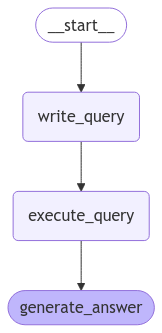

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
from pprint import pprint
for step in graph.stream(
    {"question": "How many transactions made in each day"}, stream_mode="updates"
):
    pprint(step)
    

{'write_query': {'query': 'SELECT c_date, COUNT(*) as transaction_count \n'
                          'FROM transactions \n'
                          'GROUP BY c_date \n'
                          'ORDER BY c_date ASC \n'
                          'LIMIT 10;'}}
{'execute_query': {'result': '[(datetime.date(2024, 1, 10), 84190), '
                             '(datetime.date(2024, 1, 11), 100670), '
                             '(datetime.date(2024, 1, 12), 102207), '
                             '(datetime.date(2024, 1, 13), 155699), '
                             '(datetime.date(2024, 1, 14), 115171), '
                             '(datetime.date(2024, 1, 15), 138596)]'}}
{'generate_answer': {'answer': 'The number of transactions made on each day, '
                               'according to the SQL result, are as follows:\n'
                               '\n'
                               '- On January 10, 2024, there were 84,190 '
                               'transactions.\

In [ ]:
from pprint import pprint
for step in graph.stream(
    {"question": "Can you give me total amount grouped by transaction group each day"}, stream_mode="updates",stream_mode="updates",config={"configurable": {"thread_id": "1"}},
):
    pprint(step)

{'write_query': {'query': 'SELECT c_date, c_transaction_group, SUM(c_amount) '
                          'AS total_amount\n'
                          'FROM transactions\n'
                          'GROUP BY c_date, c_transaction_group\n'
                          'ORDER BY c_date DESC, total_amount DESC\n'
                          'LIMIT 10'}}
{'execute_query': {'result': "[(datetime.date(2024, 1, 15), 'Increase', "
                             '5177151051), (datetime.date(2024, 1, 15), '
                             "'Decrease', -5110021228), (datetime.date(2024, "
                             "1, 14), 'Increase', 2366249004), "
                             "(datetime.date(2024, 1, 14), 'Decrease', "
                             '-2411835576), (datetime.date(2024, 1, 13), '
                             "'Increase', 2608515122), (datetime.date(2024, 1, "
                             "13), 'Decrease', -2678581983), "
                             "(datetime.date(2024, 1, 12), 'Increas

In [ ]:
from pprint import pprint
for step in graph.stream(
    {"question": "Can you give me total amount made from fee on 2024-01-10 "}, stream_mode="updates"stream_mode="updates",config={"configurable": {"thread_id": "1"}},
):
    pprint(step)

{'write_query': {'query': 'SELECT SUM(c_amount) AS total_fee_amount \n'
                          'FROM transactions \n'
                          "WHERE c_date = '2024-01-10' AND c_action = 'FEE' \n"
                          'LIMIT 10;'}}
{'execute_query': {'result': '[(-2650880,)]'}}
{'generate_answer': {'answer': 'The total amount made from fees on 2024-01-10 '
                               'is -2,650,880.'}}


In [34]:
from pprint import pprint

for step in graph.stream(
    {"question": "Can you give me row with highest transcaction amount on 2024-01-10 "}, stream_mode="updates",config={"configurable": {"thread_id": "1"}},
):
    pprint(step)

{'write_query': {'query': 'SELECT c_id, c_amount, c_date, c_account_id, '
                          'c_transaction_no FROM transactions WHERE c_date = '
                          "'2024-01-10' ORDER BY c_amount DESC LIMIT 1;"}}
{'execute_query': {'result': "[('1127051444', 8000000, datetime.date(2024, 1, "
                             "10), '2062687', '3400000202901265')]"}}
{'generate_answer': {'answer': 'The row with the highest transaction amount on '
                               '2024-01-10 is:\n'
                               '- Customer ID: 1127051444\n'
                               '- Transaction Amount: 8,000,000\n'
                               '- Transaction Date: 2024-01-10\n'
                               '- Account ID: 2062687\n'
                               '- Transaction Number: 3400000202901265'}}


In [36]:
from pprint import pprint
for step in graph.stream(
    {"question": "Хамгийн их гүйлгээ хийсэн хэрэглэгчийн мэдээллийг харуулна уу."}, stream_mode="updates",config={"configurable": {"thread_id": "1"}},
):
    pprint(step)

{'write_query': {'query': 'SELECT c_account_id, MAX(c_amount) as '
                          'max_transaction_amount\n'
                          'FROM transactions\n'
                          'GROUP BY c_account_id\n'
                          'ORDER BY max_transaction_amount DESC\n'
                          'LIMIT 10;'}}
{'execute_query': {'result': "[('371854', 9999999), ('3340953', 9999999), "
                             "('1460584', 8805000), ('3403128', 8000000), "
                             "('2062687', 8000000), ('3721365', 7000000), "
                             "('3718477', 6300000), ('2580403', 6085000), "
                             "('3388191', 6000000), ('3647047', 5500000)]"}}
{'generate_answer': {'answer': 'To answer the user question, "Хамгийн их '
                               'гүйлгээ хийсэн хэрэглэгчийн мэдээллийг '
                               'харуулна уу," the SQL query provided retrieves '
                               'the account IDs of users and th